In [1]:
#loss의 정의를 tf.nn.sigmoid_cross_entropy_with_logits()로 변경
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../MNIST_data',one_hot=True)

Extracting ../MNIST_data\train-images-idx3-ubyte.gz
Extracting ../MNIST_data\train-labels-idx1-ubyte.gz
Extracting ../MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data\t10k-labels-idx1-ubyte.gz


In [2]:
learning_rate=0.0002
training_epoch=100
batch_size=100
n_hidden = 256
n_input=28*28
n_noise=128
n_class=10

In [3]:
X=tf.placeholder(tf.float32, [None,n_input])
Y=tf.placeholder(tf.float32, [None,n_class])
Z=tf.placeholder(tf.float32, [None,n_noise])

def generator(noise_z,labels):
    with tf.variable_scope('generator'):
        inputs = tf.concat([noise_z,labels],axis=1)
        hidden = tf.layers.dense(inputs,n_hidden,activation=tf.nn.relu)
        output = tf.layers.dense(hidden,n_input, activation=tf.nn.sigmoid)
    return output

def discriminator(inputs, labels, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()
        inputs = tf.concat([inputs,labels], axis=1)
        hidden = tf.layers.dense(inputs,n_hidden, activation=tf.nn.relu)
        output = tf.layers.dense(hidden,1, activation=None)
    return output
    
def get_noise(batch_size, n_noise):
    return np.random.uniform(-1.,1.,size=(batch_size,n_noise))

In [4]:
G=generator(Z,Y)
D_gene = discriminator(G,Y)
D_real = discriminator(X,Y,True)

loss_D_gene = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_gene, labels=tf.zeros_like(D_gene)))
loss_D_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_real, labels=tf.ones_like(D_real)))
                                                      
loss_D = loss_D_gene+loss_D_real                                                      
loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_gene, labels=tf.ones_like(D_gene)))

#loss_D = tf.reduce_mean(tf.log(1-D_gene)+tf.log(D_real))
#loss_G = tf.reduce_mean(tf.log(D_gene))

vars_D=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
vars_G=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

train_D = tf.train.AdamOptimizer(learning_rate).minimize(loss_D,var_list=vars_D)
train_G = tf.train.AdamOptimizer(learning_rate).minimize(loss_G,var_list=vars_G)

In [5]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())

total_batch=int(mnist.train.num_examples/batch_size)
loss_val_D, loss_val_G =0, 0

print('Learning Start')

for epoch in range(training_epoch):
    for i in range(total_batch):
        batch_xs,batch_ys = mnist.train.next_batch(batch_size)
        noise = get_noise(batch_size,n_noise)
        
        _,loss_val_D = sess.run([train_D,loss_D],
                                feed_dict={X:batch_xs, Y:batch_ys, Z:noise})
        _,loss_val_G = sess.run([train_G,loss_G],
                                feed_dict={Z:noise, Y:batch_ys})
        
    print('Epoch','%04d'%(epoch+1), 
          'loss_D:{:.4}'.format(loss_val_D),
          'loss_G:{:.4}'.format(loss_val_G))
    if epoch ==0 or (epoch+1)%10 == 0 :
        sample_size = 10
        noise = get_noise(sample_size, n_noise)
        samples = sess.run(G, 
                           feed_dict = {Y:mnist.test.labels[:sample_size],Z:noise})

        fig, ax = plt.subplots(2, sample_size, figsize = (sample_size,2))

        for i in range(sample_size):
            ax[0][i].set_axis_off()
            ax[1][i].set_axis_off()
            ax[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
            ax[1][i].imshow(np.reshape(samples[i],(28,28)))
        
        plt.savefig('./result/GAN04/04_03_noise_uniform_{}.png'.format(str(epoch).zfill(3)),
                        bbox_inches='tight')
        plt.close(fig)
print('Learning Finished')

Learning Start
Epoch 0001 loss_D:0.1051 loss_G:3.617
Epoch 0002 loss_D:0.05499 loss_G:3.939
Epoch 0003 loss_D:0.05564 loss_G:4.728
Epoch 0004 loss_D:0.03054 loss_G:5.823
Epoch 0005 loss_D:0.016 loss_G:5.931
Epoch 0006 loss_D:0.01785 loss_G:5.386
Epoch 0007 loss_D:0.1614 loss_G:4.23
Epoch 0008 loss_D:0.03369 loss_G:4.76
Epoch 0009 loss_D:0.05358 loss_G:4.787
Epoch 0010 loss_D:0.09896 loss_G:4.519
Epoch 0011 loss_D:0.09109 loss_G:4.654
Epoch 0012 loss_D:0.05418 loss_G:4.639
Epoch 0013 loss_D:0.061 loss_G:4.353
Epoch 0014 loss_D:0.1026 loss_G:4.258
Epoch 0015 loss_D:0.1987 loss_G:4.407
Epoch 0016 loss_D:0.08745 loss_G:5.269
Epoch 0017 loss_D:0.103 loss_G:5.344
Epoch 0018 loss_D:0.07397 loss_G:5.558
Epoch 0019 loss_D:0.0342 loss_G:5.849
Epoch 0020 loss_D:0.03623 loss_G:5.981
Epoch 0021 loss_D:0.1082 loss_G:5.442
Epoch 0022 loss_D:0.08629 loss_G:5.549
Epoch 0023 loss_D:0.04282 loss_G:6.78
Epoch 0024 loss_D:0.08096 loss_G:5.577
Epoch 0025 loss_D:0.05951 loss_G:6.736
Epoch 0026 loss_D:0.01733

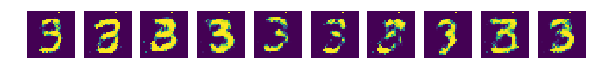

In [14]:
def one_hot(i):
    return sess.run(tf.one_hot([i],10))

def sample_show(i):
    a=sess.run(tf.one_hot([i],10))
    for k in range(9):
        a=np.append(a,one_hot(i),axis=0)
        
    sample = sess.run(G,feed_dict={Y:a,Z:get_noise(10,128)})
    fig, ax = plt.subplots(1, 10, figsize=(10, 1))
    for k in range(10):
            ax[k].set_axis_off()
            ax[k].imshow(np.reshape(sample[k],(28,28)))
    
    plt.show()

sample_show(3)